In [1]:
from pathlib import Path

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns

import searchnets

In [2]:
def cm_to_inches(cm):
    return cm / 2.54

In [3]:
mpl.style.use(['seaborn-darkgrid', 'seaborn-paper'])

paths

In [4]:
SOURCE_DATA_ROOT = pyprojroot.here('results/searchstims/source_data/3stims_SIN')

FIGURES_ROOT = pyprojroot.here('docs/paper/figures/experiment-1/searchstims-3stims')

constants

In [6]:
LEARNING_RATE = 1e-3

NET_NAMES = [
    'alexnet',
    'VGG16',
]

METHODS = [
    'transfer'
]

MODES = [
    'classify',
]

## load source data

Get just the transfer learning results, then group by network, stimulus, and set size, and compute the mean accuracy for each set size.

In [7]:
df_all = pd.read_csv(
    SOURCE_DATA_ROOT.joinpath('all.csv')
)

stim_acc_diff_df = pd.read_csv(
    SOURCE_DATA_ROOT.joinpath('stim_acc_diff.csv')
)

net_acc_diff_df = pd.read_csv(
    SOURCE_DATA_ROOT.joinpath('net_acc_diff.csv')
)

df_acc_diff_by_stim = pd.read_csv(
    SOURCE_DATA_ROOT.joinpath('acc_diff_by_stim.csv'),
    index_col='net_name'
)

columns will be stimuli, in increasing order of accuracy drop across models

In [8]:
FIG_COLUMNS = stim_acc_diff_df['stimulus'].values.tolist()
print(FIG_COLUMNS)

['RVvRHGV', 'RVvGV', '2_v_5']


rows will be nets, in decreasing order of accuracy drops across stimuli

In [9]:
FIG_ROWS = net_acc_diff_df['net_name'].values.tolist()
print(FIG_ROWS)

['VGG16', 'alexnet']


## plot figure

In [10]:
pal = sns.color_palette("rocket", n_colors=6)

In [11]:
len(pal)

6

In [12]:
cmaps = {}
for net in ('alexnet', 'CORnet_Z', 'VGG16', 'CORnet_S'):
    cmaps[net] = {
        'transfer': {
            'unit_both': pal[3],
            'mn_both': pal[2],
        },
        'initialize': {
            'unit_both': pal[5],
            'mn_both': pal[4],            
        }
    }

In [13]:
UNIT_COLORS = {
    'present': 'violet',
    'absent': 'lightgreen',
    'both': 'darkgrey'
}

# default colors used for plotting mean across sampling units in each condition
MN_COLORS = {
    'present': 'magenta',
    'absent': 'lawngreen',
    'both': 'black'
}


def metric_v_set_size_df(df, net_name, method, stimulus, metric, conditions,
                         unit_colors=UNIT_COLORS, mn_colors=MN_COLORS,
                         ax=None, title=None, save_as=None, figsize=(10, 5),
                         set_xlabel=False, set_ylabel=False, set_ylim=True,
                         ylim=(0, 1.1), yticks=None, plot_mean=True, add_legend=False, dpi=600):
    """plot accuracy as a function of visual search task set size
    for models trained on a single task or dataset

    Accepts a Pandas dataframe and column names that determine what to plot.
    Dataframe is produces by searchstims.utils.general.results_csv function.

    Parameters
    ----------
    df : pandas.Dataframe
        path to results.gz file saved after measuring accuracy of trained networks
        on test set of visual search stimuli
    net_name : str
        name of neural net architecture. Must be a value in the 'net_name' column
        of df.
    method : str
        method used for training. Must be a value in the 'method' column of df.
    stimulus : str
        type of visual search stimulus, e.g. 'RVvGV', '2_v_5'. Must be a value in
        the 'stimulus' column of df.
    metric : str
        metric to plot. One of {'acc', 'd_prime'}.
    conditions : list, str
        conditions to plot. One of {'present', 'absent', 'both'}. Corresponds to
        'target_condition' column in df.

    Other Parameters
    ----------------
    unit_colors : dict
        mapping of conditions to colors used for plotting 'sampling units', i.e. each trained
        network. Default is UNIT_COLORS defined in this module.
    mn_colors : dict
        mapping of conditions to colors used for plotting mean across 'sampling units'
        (i.e., each trained network). Default is MN_COLORS defined in this module.
    ax : matplotlib.Axis
        axis on which to plot figure. Default is None, in which case a new figure with
        a single axis is created for the plot.
    title : str
        string to use as title of figure. Default is None.
    save_as : str
        path to directory where figure should be saved. Default is None, in which
        case figure is not saved.
    figsize : tuple
        (width, height) in inches. Default is (10, 5). Only used if ax is None and a new
        figure is created.
    set_xlabel : bool
        if True, set the value of xlabel to "set size". Default is False.
    set_ylabel : bool
        if True, set the value of ylabel to metric. Default is False.
    set_ylim : bool
        if True, set the y-axis limits to the value of ylim.
    ylim : tuple
        with two elements, limits for y-axis. Default is (0, 1.1).
    plot_mean : bool
        if True, find mean accuracy and plot as a separate solid line. Default is True.
    add_legend : bool
        if True, add legend to axis. Default is False.

    Returns
    -------
    None
    """
    if ax is None:
        fig, ax = plt.subplots(dpi=dpi, figsize=figsize)

    df = df[(df['net_name'] == net_name)
            & (df['method'] == method)
            & (df['stimulus'] == stimulus)]
    
    if not all(
            [df['target_condition'].isin([targ_cond]).any() for targ_cond in conditions]
    ):
        raise ValueError(f'not all target conditions specified were found in dataframe.'
                         f'Target conditions specified were: {conditions}')

    handles = []
    labels = []

    set_sizes = None  # because we verify set sizes is the same across conditions
    net_nums = df['net_number'].unique()
    # get metric across set sizes for each training replicate
    # we end up with a list of vectors we can pass to ax.plot,
    # so that the 'line' for each training replicate gets plotted
    for targ_cond in conditions:
        metric_vals = []
        for net_num in net_nums:
            metric_vals.append(
                df[(df['net_number'] == net_num)
                   & (df['target_condition'] == targ_cond)][metric].values
            )

            curr_set_size = df[(df['net_number'] == net_num)
                               & (df['target_condition'] == targ_cond)]['set_size'].values
            if set_sizes is None:
                set_sizes = curr_set_size
            else:
                if not np.array_equal(set_sizes, curr_set_size):
                    raise ValueError(
                        f'set size for net number {net_num}, '
                        f'target condition {targ_cond},  did not match others'
                    )
        for row_num, arr_metric in enumerate(metric_vals):
            x = np.arange(1, len(set_sizes) + 1) * 2
            # just label first row, so only one entry shows up in legend
            if row_num == 0:
                label = f'training replicate, {method}'
            else:
                label = None
            ax.plot(x, arr_metric, color=unit_colors[targ_cond], linewidth=1,
                    linestyle='--', alpha=0.95, label=label)
            ax.set_xticks(x)
            ax.set_xticklabels(set_sizes)
            ax.set_xlim([0, x.max() + 2])

        if plot_mean:
            mn_metric = np.asarray(metric_vals).mean(axis=0)
            if targ_cond == 'both':
                mn_metric_label = f'mean, {method}'
            else:
                mn_metric_label = f'mean {metric}, {targ_cond}, {method}'
            labels.append(mn_metric_label)
            mn_metric_line, = ax.plot(x, mn_metric,
                                      color=mn_colors[targ_cond], linewidth=1.5, 
                                      alpha=0.65,
                                      label=mn_metric_label)
            ax.set_xticks(x)
            ax.set_xticklabels(set_sizes)
            ax.set_xlim([0, x.max() + 2])
            handles.append(mn_metric_line)

    if title:
        ax.set_title(title)
    if set_xlabel:
        ax.set_xlabel('set size')
    if set_ylabel:
        ax.set_ylabel(metric)
    if yticks is not None:
        ax.set_yticks(yticks)
    if set_ylim:
        ax.set_ylim(ylim)

    if add_legend:
        ax.legend(handles=handles,
                  labels=labels,
                  loc='lower left')

    if save_as:
        plt.savefig(save_as)

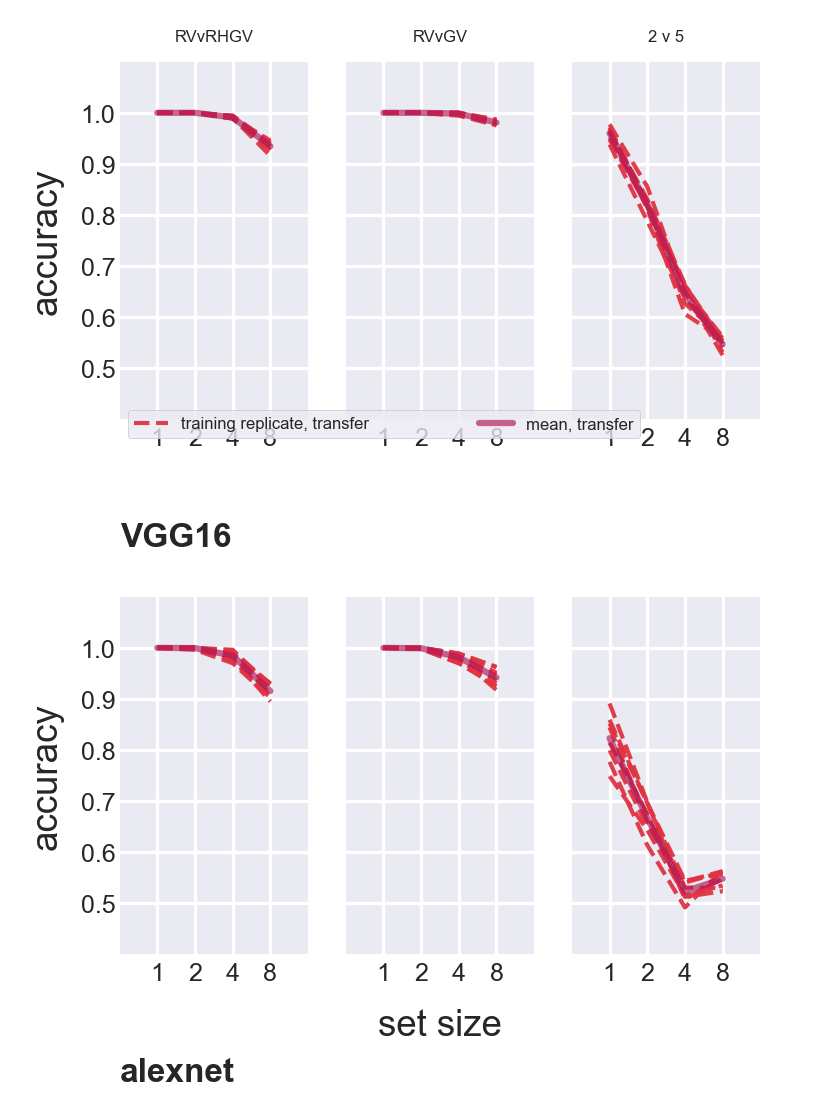

In [18]:
if '3stims' in str(FIGURES_ROOT):
    FIGSIZE = tuple(cm_to_inches(size) for size in (7, 10))
elif '10stims' in str(FIGURES_ROOT):
    FIGSIZE = tuple(cm_to_inches(size) for size in (17.4, 10))

DPI = 300

n_rows = len(FIG_ROWS)
n_cols = len(FIG_COLUMNS)
fig, ax = plt.subplots(n_rows, n_cols, sharey=True, figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(hspace=0.5)

LABELSIZE = 6
XTICKPAD = 2
YTICKPAD = 1

for ax_ in ax.ravel():
    ax_.xaxis.set_tick_params(pad=XTICKPAD, labelsize=LABELSIZE)
    ax_.yaxis.set_tick_params(pad=YTICKPAD, labelsize=LABELSIZE)
    

STIM_FONTSIZE = 4

add_legend = False

for row, net_name in enumerate(FIG_ROWS):
    df_this_net = df_all[df_all['net_name'] == net_name]

    for method in ['transfer']:
        for col, stim_name in enumerate(FIG_COLUMNS):
                unit_colors = {'both': cmaps[net_name][method]['unit_both']}
                mn_colors = {'both': cmaps[net_name][method]['mn_both']}

                ax[row, col].set_axisbelow(True)  # so grid is behind
                metric_v_set_size_df(df=df_this_net, 
                                     net_name=net_name,
                                     method=method, 
                                     stimulus=stim_name,
                                     metric='accuracy', 
                                     conditions=['both'],
                                     unit_colors=unit_colors,
                                     mn_colors=mn_colors,
                                     set_ylim=True,
                                     ax=ax[row, col],
                                     ylim=(0.4, 1.1),
                                     yticks=(0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
                                     add_legend=add_legend)
                

                if row == 0:
                    title = stim_name.replace('_',' ')
                    ax[row, col].set_title(title, 
                                           fontsize=STIM_FONTSIZE,
                                           pad=5)  # pad so we can put image over title without it showing
                if col == 0:
                    ax[row, col].set_ylabel('accuracy')
                    net_name_for_fig = net_name.replace('_', ' ')
                    ax[row, col].text(0, 0.15, net_name_for_fig, fontweight='bold', fontsize=8)

# add a big axis, hide frame
big_ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.grid(False)

handles, labels = ax[0, 0].get_legend_handles_labels()
LEGEND_FONTSIZE = 4

if '3stims' in str(FIGURES_ROOT):
    BBOX_TO_ANCHOR = (0.0125, 0.535, 0.8, .075)
elif '10stims' in str(FIGURES_ROOT):
    BBOX_TO_ANCHOR = (0.005, 0.55, 0.4, .075)

big_ax.legend(handles, labels, 
              bbox_to_anchor=BBOX_TO_ANCHOR,
              ncol=2, mode="expand", frameon=True,
              borderaxespad=0., fontsize=LEGEND_FONTSIZE);

big_ax.set_xlabel("set size", labelpad=0.1);

# for ext in ('svg', 'png'):
#     fig_path = FIGURES_ROOT.joinpath(
#         f'acc-v-set-size/acc-v-set-size.{ext}'
#     )
#     plt.savefig(fig_path)